In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
radbio_data = pd.read_csv("GSE43151_gs.csv")
num_genes = radbio_data.shape[1] - 1 
gene_ids = [int(i) for i in radbio_data.columns[0:num_genes]]
print(len(gene_ids))
gene_dictionary = pd.read_csv("ncbi_dataset.tsv", sep='\t', header=0)
print(gene_dictionary)

10874
       NCBI GeneID     Symbol  \
0             7157       TP53   
1             1956       EGFR   
2             7124        TNF   
3              348       APOE   
4             7422      VEGFA   
...            ...        ...   
45507         9596     OR1R1P   
45508         9597  SMAD5-AS1   
45509        96626      LIMS3   
45510         9808   KIAA0087   
45511         9831     ZNF623   

                                             Description Taxonomic Name  \
0                                      tumor protein p53   Homo sapiens   
1                       epidermal growth factor receptor   Homo sapiens   
2                                  tumor necrosis factor   Homo sapiens   
3                                       apolipoprotein E   Homo sapiens   
4                   vascular endothelial growth factor A   Homo sapiens   
...                                                  ...            ...   
45507  olfactory receptor family 1 subfamily R member...   Homo sapiens 

In [3]:
print(set(gene_dictionary['Gene Type']))
print(gene_dictionary.columns)

{'snRNA', 'ncRNA', 'PROTEIN_CODING', 'scRNA', 'snoRNA', 'rRNA', 'tRNA'}
Index(['NCBI GeneID', 'Symbol', 'Description', 'Taxonomic Name', 'Common Name',
       'Gene Type', 'Transcripts', 'Gene Group Identifier',
       'Gene Group Method'],
      dtype='object')


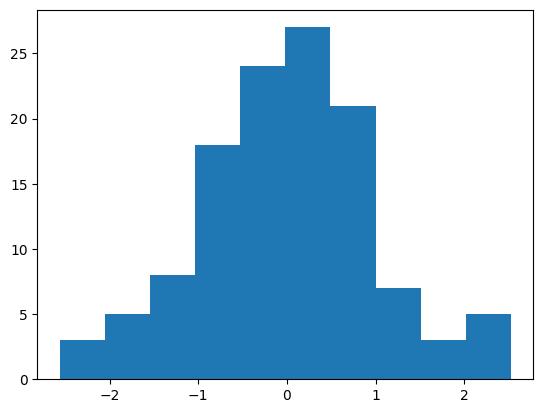

In [4]:
plt.hist(radbio_data.iloc[:,0])
plt.show()

In [5]:
# Which genes are in the dataset and are also protein coding 
gene_data = gene_dictionary.loc[gene_dictionary['NCBI GeneID'].isin(gene_ids)]
protein_gene_data = gene_data.loc[gene_data['Gene Type']=='PROTEIN_CODING']
#print(protein_gene_data)


In [6]:
final_gene_set = [str(i) for i in protein_gene_data['NCBI GeneID']]
final_data_set = radbio_data[final_gene_set]
final_column_set = final_gene_set + ["Dose"]
final_data_set_w_condition = radbio_data[final_column_set]
ZNF717_id = protein_gene_data.loc[protein_gene_data['Symbol']=='ZNF717']['NCBI GeneID'].values[0]
print(ZNF717_id, str(ZNF717_id) in final_gene_set)

100131827 True


In [11]:
print(final_data_set)

         7157      7124       348      4524      3091      2099       351  \
0   -2.705546 -1.077350 -0.026138 -0.509090  1.485981  0.233256  0.696355   
1   -1.586763 -1.308024 -0.351617 -1.047694  1.926247  0.066700  1.102323   
2   -2.283460 -0.281654 -0.291284 -2.115849  0.205207  0.443262  0.814027   
3   -1.312153 -0.367185 -0.645341 -0.758025  1.541014 -0.784185 -0.898099   
4   -1.032457 -0.582308 -0.785059 -0.522669  1.415938  0.254981  0.358048   
..        ...       ...       ...       ...       ...       ...       ...   
116 -0.264566 -0.074307 -0.026138  0.061196 -0.685332 -0.324345 -0.195010   
117 -0.223883  1.524860  0.316805 -0.137952  0.495382  1.004484 -0.021444   
118  1.342413  0.705838  0.591478  1.880680 -1.435785 -2.109393 -0.271496   
119  1.566170  0.477756  1.642535 -0.676555 -1.320715 -2.022494 -1.936553   
120  1.057632  2.051004 -0.886672  1.360180  0.765545  0.345501 -1.439390   

         1636       672      6774  ...     91664     92106     92285  \
0  

In [12]:
# Permutation testing
corr_mat = final_data_set.corr('pearson').to_numpy()
np.fill_diagonal(corr_mat, 0)
print(np.max(corr_mat))
random_corr_coef = []
for i in range(100):
    shuffled_array = np.zeros(final_data_set.shape)
    for row in np.arange(final_data_set.shape[0]):
        shuffled_array[row] = np.random.permutation(final_data_set.iloc[row])
    shuffled_final_data_set = pd.DataFrame(data=shuffled_array)
    shuffle_corr_mat = shuffled_final_data_set.corr('pearson')

    shuffle_corr_mat = shuffle_corr_mat.to_numpy()
    np.fill_diagonal(shuffle_corr_mat, 0)
    random_corr_coef.append(np.max(shuffle_corr_mat))

0.9850945543290598


KeyboardInterrupt: 

In [ ]:
#np.savetxt('random_corr_coef.txt', np.array(random_corr_coef))
random_corr_coef = np.loadtxt('random_corr_coef.txt')

In [ ]:
import scipy.stats as st
ci_interval = st.t.interval(0.95, len(random_corr_coef)-1, loc=np.mean(random_corr_coef), scale=st.sem(random_corr_coef))
cutoff = ci_interval[1]

In [ ]:
corr_mat[corr_mat<=cutoff] = 0
corr_mat[corr_mat>cutoff] = 1
print(f"Superstructure contains {np.sum(corr_mat)} edges which is {np.sum(corr_mat)/(corr_mat.shape[0]**2)} fraction of all possible edges")

In [ ]:
from cd_v_partition.causal_discovery import ges_local_learn
final_data_set_w_condition = final_data_set_w_condition.rename(mapper={"Dose":"target"}, axis=1)
obs_final_data_set_w_condition = final_data_set_w_condition
obs_final_data_set_w_condition['target'] = np.zeros(radbio_data.shape[0])
est_dag = ges_local_learn((corr_mat, obs_final_data_set_w_condition), use_skel=True)

In [ ]:
print(np.sum(est_dag))

In [ ]:
final_column_set = list(final_column_set)

In [ ]:
df_edges_mod = pd.read_csv("edges_dag_w_ss_corr.csv", sep=' ', header=None).iloc[:,0:2]
values = []
for _,row in df_edges_mod.iterrows():
    ncbi_gene_id_start = int(final_column_set[row[0]])
    ncbi_gene_id_end = int(final_column_set[row[1]])

    start = gene_dictionary.loc[gene_dictionary['NCBI GeneID'] == ncbi_gene_id_start]['Symbol'].values
    end = gene_dictionary.loc[gene_dictionary['NCBI GeneID'] == ncbi_gene_id_end]['Symbol'].values
    print(start, end)
    values.append([start,end])
df_edges_mod_by_symbol = pd.DataFrame(data=values, columns=['start', 'end'])
print(df_edges_mod_by_symbol)

In [ ]:
import networkx as nx
graph = nx.from_edgelist(values)
print(graph)
nx.write_gexf(graph, "dag_w_ss_corr_mod.gexf")

In [14]:
ppi_n = pd.read_csv("/homes/mshukla/lucid/9606.protein.physical.links.v11.5.txt", sep=' ')
ppi_n.head()

protein1              protein2  combined_score
0  9606.ENSP00000000233  9606.ENSP00000264718             156
1  9606.ENSP00000000233  9606.ENSP00000346046             177
2  9606.ENSP00000000233  9606.ENSP00000347134             162
3  9606.ENSP00000000233  9606.ENSP00000317469             379
4  9606.ENSP00000000233  9606.ENSP00000302393             287

In [15]:
dict_ensemble_pid_to_gid = {}
dict_ensemble_pid_to_gene_name = {}
with open("/homes/mshukla/lucid/Homo_sapiens.GRCh38.90.gtf", 'r') as file:
    for line in file: 
        if "ENSP" in line:
            gene_name = None
            gene_id = None
            protein_id = None
            tokens = line.split(";")
            for t in tokens:
                if "gene_name" in t:
                    gene_name = t.split(" ")[-1][1:-1]
                if "gene_id" in t:
                    gene_id = t.split(" ")[-1][1:-1]
                if "protein_id" in t:
                    protein_id = t.split(" ")[-1][1:-1]
            if gene_name is not None and gene_id is not None and protein_id is not None:
                dict_ensemble_pid_to_gid[protein_id] = gene_id
                dict_ensemble_pid_to_gene_name[protein_id] = gene_name
    print(dict_ensemble_pid_to_gene_name)

{'ENSP00000493376': 'OR4F5', 'ENSP00000334393': 'OR4F5', 'ENSP00000409316': 'OR4F29', 'ENSP00000329982': 'OR4F16', 'ENSP00000411579': 'SAMD11', 'ENSP00000393181': 'SAMD11', 'ENSP00000342313': 'SAMD11', 'ENSP00000480870': 'SAMD11', 'ENSP00000482138': 'SAMD11', 'ENSP00000480678': 'SAMD11', 'ENSP00000478421': 'SAMD11', 'ENSP00000484256': 'SAMD11', 'ENSP00000484643': 'SAMD11', 'ENSP00000484820': 'SAMD11', 'ENSP00000482090': 'SAMD11', 'ENSP00000349216': 'SAMD11', 'ENSP00000412228': 'SAMD11', 'ENSP00000317992': 'NOC2L', 'ENSP00000343930': 'KLHL17', 'ENSP00000479477': 'KLHL17', 'ENSP00000463694': 'KLHL17', 'ENSP00000368720': 'PLEKHN1', 'ENSP00000368719': 'PLEKHN1', 'ENSP00000368717': 'PLEKHN1', 'ENSP00000462558': 'PLEKHN1', 'ENSP00000343864': 'PERM1', 'ENSP00000414022': 'PERM1', 'ENSP00000393198': 'HES4', 'ENSP00000304595': 'HES4', 'ENSP00000425085': 'HES4', 'ENSP00000485643': 'ISG15', 'ENSP00000485313': 'ISG15', 'ENSP00000368699': 'ISG15', 'ENSP00000368678': 'AGRN', 'ENSP00000484607': 'AGRN'

In [16]:
edges_by_symbol= []
edges_by_ncbi_id=[]
# map from symbol to ncbi id for genes in the dataset
symbol_to_gene = dict(zip(protein_gene_data['Symbol'].to_list(), protein_gene_data['NCBI GeneID'].to_list()))
for i,edge in ppi_n.iterrows():
    start = str(edge['protein1'][5:])
    end = str(edge['protein2'][5:])
    try:
        gene_start = dict_ensemble_pid_to_gene_name[start]
        gene_end = dict_ensemble_pid_to_gene_name[end]
        id_start = symbol_to_gene[gene_start]
        id_end = symbol_to_gene[gene_end]
        edges_by_symbol.append([gene_start,gene_end])
        edges_by_ncbi_id.append([id_start,id_end])

    except:
        #print(f"Protein {start} or {end} not found")
        continue

In [17]:
df_edge_by_gene = pd.DataFrame(data=edges_by_ncbi_id, columns=['start', 'end'])
print(df_edge_by_gene.head())
df_edge_by_gene.to_csv("edges_ppi_by_gene_id.csv", index=False, header=True)

   start    end
0   4074   9367
1   4074   1508
2   4074    160
3   4074  55275
4   4074    162


In [28]:
print(ZNF717_id in list(df_edge_by_gene['end'].values))

True


In [11]:
df_edge_by_gene = pd.read_csv("edges_ppi_by_gene.csv", header=0)
print(df_edge_by_gene.shape)
print(f"Superstructure contains {df_edge_by_gene.shape[0]} edges which is {df_edge_by_gene.shape[0]/(num_genes**2)} fraction of all possible edges")

(1963440, 2)
Superstructure contains 1963440 edges which is 0.01660500371283499 fraction of all possible edges


In [16]:
print(protein_gene_data.loc[protein_gene_data["NCBI GeneID"] == 4074])
print(edges_by_ncbi_id[0], edges_by_symbol[0])

      NCBI GeneID Symbol                                     Description  \
4709         4074   M6PR  mannose-6-phosphate receptor, cation dependent   

     Taxonomic Name Common Name       Gene Type  Transcripts  \
4709   Homo sapiens       human  PROTEIN_CODING         18.0   

      Gene Group Identifier Gene Group Method  
4709                 4074.0     NCBI Ortholog  
[4074, 9367] ['M6PR', 'RAB9A']


In [7]:
import networkx as nx
edges = pd.read_csv("edges_dag_w_ss_ppi_de_genes_ec.csv",sep=' ', header=None).iloc[:,0:2]
values = []
for _,row in edges.iterrows():
    ncbi_gene_id_start = int(final_column_set[row[0]])
    ncbi_gene_id_end = int(final_column_set[row[1]])

    start = gene_dictionary.loc[gene_dictionary['NCBI GeneID'] == ncbi_gene_id_start]['Symbol'].values[0]
    end = gene_dictionary.loc[gene_dictionary['NCBI GeneID'] == ncbi_gene_id_end]['Symbol'].values[0]
    values.append([start,end])
df_edges_mod_by_symbol = pd.DataFrame(data=values, columns=['start', 'end'])
print(df_edges_mod_by_symbol)

graph = nx.from_edgelist(values, create_using=nx.DiGraph)
print(graph)
nx.write_gexf(graph, "dag_w_ss_ppi_de_genes_ec_dir.gexf")

         start      end
0        SYCE2     PGLS
1          LSR    SIN3A
2         PGLS    TBL1X
3       ZNF324    MBNL2
4      IRF2BP2  SELENOF
...        ...      ...
19590    THOC6  FAM111A
19591     BRD1     BRAF
19592   NT5DC1   CAVIN1
19593    ZBTB1     CD86
19594     IQCK    HARS2

[19595 rows x 2 columns]
DiGraph with 6646 nodes and 19595 edges
